# Siamese


# Import libraries

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import scipy
import os
import string
import csv
import random as rn

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing
import spacy
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import re
from string import punctuation
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Dense, Dropout, LSTM

import tensorflow as tf
from tensorflow import keras
from keras import optimizers
import shutil
from sklearn import metrics
from keras import layers
from sklearn.utils import class_weight

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# Load dataset

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cp --verbose -R "/content/drive/MyDrive/Quora/Dataset" "/content"

'/content/drive/MyDrive/Quora/Dataset' -> '/content/Dataset'
'/content/drive/MyDrive/Quora/Dataset/validation.csv' -> '/content/Dataset/validation.csv'
'/content/drive/MyDrive/Quora/Dataset/test.csv' -> '/content/Dataset/test.csv'
'/content/drive/MyDrive/Quora/Dataset/training.csv' -> '/content/Dataset/training.csv'
'/content/drive/MyDrive/Quora/Dataset/augmented_training.csv' -> '/content/Dataset/augmented_training.csv'
'/content/drive/MyDrive/Quora/Dataset/val_cosine_score.csv' -> '/content/Dataset/val_cosine_score.csv'


# Set Parameters

In [ ]:
DATASET_PATH = '/content/Dataset'

LOCAL_MODELS_FOLDER = "/content/Models"
if not os.path.exists(LOCAL_MODELS_FOLDER):
  os.makedirs(LOCAL_MODELS_FOLDER)
GLOBAL_MODELS_FOLDER = "/content/drive/My Drive/Quora/Models/Siamese"

HISTORIES_FOLDER = "/content/drive/My Drive/Quora/Histories/Siamese"

BATCH_SIZE = 64
SEED = 24

# Utility Functions

In [ ]:
def set_seed ():
  ''' 
  set_seed is used to obtain reproducible results using keras during the development phase
  '''
  # The below is necessary for reproducible results of certain Python hash-based operations.
  os.environ["PYTHONHASHSEED"]="0"
  # The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
  np.random.seed(SEED)
  # The below is necessary for starting core Python generated random numbers in a well-defined state.
  rn.seed(SEED)
  # The below tf.random.set_seed will make random number generation in TensorFlow have a well-defined initial state.
  tf.random.set_seed(SEED)

def show_training_and_validation_performance(history):
  '''
  show_training_and_validation_performance is used to plot the performances during the training phase
  :param history: object in which are recorded all the events
  '''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

def compile_model (model, optimizer='adam', learning_rate = 0.001, loss='binary_crossentropy'):
  '''
  compile_model is used to compile the current model
  :param model: model to compile
  :param optimizer: optimizer to be used
  :param learning_rate: learning rate parameter for the optimizer
  '''
  if optimizer == 'adam':
    model.compile(loss=loss,
      optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
      metrics=["accuracy"])
  elif optimizer == 'rmsprop':
    model.compile(loss=loss,
                  optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate),
                  metrics=['accuracy'])
  model.summary()

def run_model (model, model_name, X_train, y_train, X_validation, y_validation, epochs = 50, patience = 5, monitor='val_loss', class_weight=None):
  '''
  run_model is used to run the current mode
  :param model: model to run
  :param model_name: name given to save the model
  :param epochs: how many epochs to do
  :param patience: patience value for Early Stopping
  :param monitor: what to monitor for Early Stopping and Model Checkpoint
  '''
  # local save path for the models
  save_path = LOCAL_MODELS_FOLDER + '/' + model_name + '.h5'
  callbacks_list = [
                  keras.callbacks.EarlyStopping(monitor=monitor, patience=patience),
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor=monitor,
                      verbose=1,
                      save_best_only=True)
                  ]
  history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_validation, y_validation),
                    callbacks=callbacks_list,
                    class_weight=class_weight)
  # save on Drive only the best model
  shutil.copy(save_path, GLOBAL_MODELS_FOLDER + '/' + model_name + '.h5')

  # save on Drive also the history object
  history_df = pd.DataFrame(history.history)
  with open(HISTORIES_FOLDER + '/' + model_name + '.csv', mode='w+') as f:
    history_df.to_csv(f)

  show_training_and_validation_performance(history)

def evaluate_model (model, X_test, y_test):
  '''
  evaluate_model is used to plot some statistics about the performance on the test set
  :param model: model to consider
  '''
  y_score = model.predict(X_test)
  y_pred = np.rint(y_score) # to have 0 or 1
  y_true = y_test
  print("Classification report: ")
  print(metrics.classification_report(y_true,y_pred,digits = 4))
  metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

  # ROC curve
  fpr,tpr,th = metrics.roc_curve(y_true,y_score)
  roc_auc = metrics.roc_auc_score(y_true,y_score)

  plt.figure()
  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  plt.legend(loc="lower right")
  plt.show()

def txt_process(input_text):
  '''
  txt_process is used to preprocess a question
  :param input_text: input string
  :return: the cleaned version of the input string
  '''
  # Removing punctuation from input text
  input_text = ''.join([x for x in input_text if x not in punctuation])
  # Cleaning the text
  input_text = re.sub(r"[^A-Za-z0-9]", " ", input_text)
  input_text = re.sub(r"\'s", " ", input_text)
  # remove stop words
  input_text = input_text.split()
  input_text = [x for x in input_text if not x in stop_words]
  input_text = " ".join(input_text)
  # return a list of words
  return(input_text)

# Preprocessing data

In [ ]:
set_seed()

In [ ]:
train_questions = pd.read_csv(DATASET_PATH + '/training.csv')
validation_questions = pd.read_csv(DATASET_PATH + '/validation.csv')
test_questions = pd.read_csv(DATASET_PATH + '/test.csv')

In [ ]:
train_questions

,id,qid1,qid2,question1,question2,is_duplicate
0,216036,322068,322069,How can I sell at Snapdeal? What are the terms...,What are the payment terms for online marketpl...,0
1,241554,353581,353582,Why are most prosecutors in American courts no...,Why does a country like USA where law enforcem...,0
2,208738,312815,312816,What are some good government jobs without a c...,Are there any good companies that hire smart p...,0
3,102714,104282,77231,What would happen if humans no longer needed t...,What would the world be like if humans didn't ...,1
4,397304,178955,34172,How do I shave my bikini line?,What is the best way to shave the bikini area?,1
...,...,...,...,...,...,...
323426,189944,8395,34814,Is it true that the US is funding ISIS?,Is it really true that US is backing ISIS?,1
323427,330730,110579,457526,How do I play in share market in India?,How can I study and invest in the Indian share...,0
323428,143114,226824,175127,What is the difference between laundry deterge...,How safe is it to use non-HE detergent in a HE...,0
323429,10918,21121,21122,Would you consider teaching as a full time job...,Would you consider teaching as a full time job?,1


In [ ]:
train_questions['question1_cleaned'] = train_questions.apply(lambda x: txt_process(x['question1']), axis = 1)
train_questions['question2_cleaned'] = train_questions.apply(lambda x: txt_process(x['question2']), axis = 1)

validation_questions['question1_cleaned'] = validation_questions.apply(lambda x: txt_process(x['question1']), axis = 1)
validation_questions['question2_cleaned'] = validation_questions.apply(lambda x: txt_process(x['question2']), axis = 1)

test_questions['question1_cleaned'] = test_questions.apply(lambda x: txt_process(x['question1']), axis = 1)
test_questions['question2_cleaned'] = test_questions.apply(lambda x: txt_process(x['question2']), axis = 1)

In [ ]:
train_questions

,id,qid1,qid2,question1,question2,is_duplicate,question1_cleaned,question2_cleaned
0,216036,322068,322069,How can I sell at Snapdeal? What are the terms...,What are the payment terms for online marketpl...,0,How I sell Snapdeal What terms conditions,What payment terms online marketplaces like Fl...
1,241554,353581,353582,Why are most prosecutors in American courts no...,Why does a country like USA where law enforcem...,0,Why prosecutors American courts notoriously di...,Why country like USA law enforcements strict l...
2,208738,312815,312816,What are some good government jobs without a c...,Are there any good companies that hire smart p...,0,What good government jobs without college degree,Are good companies hire smart people without c...
3,102714,104282,77231,What would happen if humans no longer needed t...,What would the world be like if humans didn't ...,1,What would happen humans longer needed sleep,What would world like humans didnt need sleep
4,397304,178955,34172,How do I shave my bikini line?,What is the best way to shave the bikini area?,1,How I shave bikini line,What best way shave bikini area
...,...,...,...,...,...,...,...,...
323426,189944,8395,34814,Is it true that the US is funding ISIS?,Is it really true that US is backing ISIS?,1,Is true US funding ISIS,Is really true US backing ISIS
323427,330730,110579,457526,How do I play in share market in India?,How can I study and invest in the Indian share...,0,How I play share market India,How I study invest Indian share market
323428,143114,226824,175127,What is the difference between laundry deterge...,How safe is it to use non-HE detergent in a HE...,0,What difference laundry detergent bleach laund...,How safe use nonHE detergent HE laundry washer
323429,10918,21121,21122,Would you consider teaching as a full time job...,Would you consider teaching as a full time job?,1,Would consider teaching full time job Why,Would consider teaching full time job


# Text to Feature
Let’s stack both question IDs together so we can cover all words from both columns. Then we can tokenize these words to convert them to numbers.

In [ ]:
#stacking
question_text = np.hstack([train_questions.question1_cleaned, train_questions.question2_cleaned])

#tokenizing
tokenizer = Tokenizer()
tokenizer.fit_on_texts(question_text)

#creating new columns for both ids where tokenized form of sentence is created
train_questions['tokenizer_1'] = tokenizer.texts_to_sequences(train_questions.question1_cleaned)
train_questions['tokenizer_2'] = tokenizer.texts_to_sequences(train_questions.question2_cleaned)

validation_questions['tokenizer_1'] = tokenizer.texts_to_sequences(validation_questions.question1_cleaned)
validation_questions['tokenizer_2'] = tokenizer.texts_to_sequences(validation_questions.question2_cleaned)

test_questions['tokenizer_1'] = tokenizer.texts_to_sequences(test_questions.question1_cleaned)
test_questions['tokenizer_2'] = tokenizer.texts_to_sequences(test_questions.question2_cleaned)

train_questions.head(5)

,id,qid1,qid2,question1,question2,is_duplicate,question1_cleaned,question2_cleaned,tokenizer_1,tokenizer_2
0,216036,322068,322069,How can I sell at Snapdeal? What are the terms...,What are the payment terms for online marketpl...,0,How I sell Snapdeal What terms conditions,What payment terms online marketplaces like Fl...,"[3, 2, 521, 4904, 1, 465, 3145]","[1, 1602, 465, 46, 14381, 12, 2222, 7715, 4904..."
1,241554,353581,353582,Why are most prosecutors in American courts no...,Why does a country like USA where law enforcem...,0,Why prosecutors American courts notoriously di...,Why country like USA law enforcements strict l...,"[4, 28362, 291, 4729, 32475, 12230, 1099, 144,...","[4, 134, 12, 207, 403, 75955, 6163, 2007, 1220..."
2,208738,312815,312816,What are some good government jobs without a c...,Are there any good companies that hire smart p...,0,What good government jobs without college degree,Are good companies hire smart people without c...,"[1, 13, 163, 333, 43, 124, 417]","[41, 13, 180, 796, 769, 10, 43, 124, 417]"
3,102714,104282,77231,What would happen if humans no longer needed t...,What would the world be like if humans didn't ...,1,What would happen humans longer needed sleep,What would world like humans didnt need sleep,"[1, 14, 118, 474, 1191, 1142, 411]","[1, 14, 49, 12, 474, 489, 91, 411]"
4,397304,178955,34172,How do I shave my bikini line?,What is the best way to shave the bikini area?,1,How I shave bikini line,What best way shave bikini area,"[3, 2, 3378, 6389, 701]","[1, 5, 17, 3378, 6389, 618]"


In [ ]:
train_questions['tokenizer'] = train_questions['tokenizer_1'] + train_questions['tokenizer_2']
validation_questions['tokenizer'] = validation_questions['tokenizer_1'] + validation_questions['tokenizer_2']
test_questions['tokenizer'] = test_questions['tokenizer_1'] + test_questions['tokenizer_2']

# defining max length
m_len = 25

# max tokens
max_token = np.max(train_questions.tokenizer.max())
print("Max token: ", max_token)
train_questions

Max token:  75937


,id,qid1,qid2,question1,question2,is_duplicate,question1_cleaned,question2_cleaned,tokenizer_1,tokenizer_2,tokenizer
0,216036,322068,322069,How can I sell at Snapdeal? What are the terms...,What are the payment terms for online marketpl...,0,How I sell Snapdeal What terms conditions,What payment terms online marketplaces like Fl...,"[3, 2, 521, 4904, 1, 465, 3145]","[1, 1602, 465, 46, 14381, 12, 2222, 7715, 4904...","[3, 2, 521, 4904, 1, 465, 3145, 1, 1602, 465, ..."
1,241554,353581,353582,Why are most prosecutors in American courts no...,Why does a country like USA where law enforcem...,0,Why prosecutors American courts notoriously di...,Why country like USA law enforcements strict l...,"[4, 28362, 291, 4729, 32475, 12230, 1099, 144,...","[4, 134, 12, 207, 403, 75955, 6163, 2007, 1220...","[4, 28362, 291, 4729, 32475, 12230, 1099, 144,..."
2,208738,312815,312816,What are some good government jobs without a c...,Are there any good companies that hire smart p...,0,What good government jobs without college degree,Are good companies hire smart people without c...,"[1, 13, 163, 333, 43, 124, 417]","[41, 13, 180, 796, 769, 10, 43, 124, 417]","[1, 13, 163, 333, 43, 124, 417, 41, 13, 180, 7..."
3,102714,104282,77231,What would happen if humans no longer needed t...,What would the world be like if humans didn't ...,1,What would happen humans longer needed sleep,What would world like humans didnt need sleep,"[1, 14, 118, 474, 1191, 1142, 411]","[1, 14, 49, 12, 474, 489, 91, 411]","[1, 14, 118, 474, 1191, 1142, 411, 1, 14, 49, ..."
4,397304,178955,34172,How do I shave my bikini line?,What is the best way to shave the bikini area?,1,How I shave bikini line,What best way shave bikini area,"[3, 2, 3378, 6389, 701]","[1, 5, 17, 3378, 6389, 618]","[3, 2, 3378, 6389, 701, 1, 5, 17, 3378, 6389, ..."
...,...,...,...,...,...,...,...,...,...,...,...
323426,189944,8395,34814,Is it true that the US is funding ISIS?,Is it really true that US is backing ISIS?,1,Is true US funding ISIS,Is really true US backing ISIS,"[6, 179, 37, 1577, 1303]","[6, 78, 179, 37, 10458, 1303]","[6, 179, 37, 1577, 1303, 6, 78, 179, 37, 10458..."
323427,330730,110579,457526,How do I play in share market in India?,How can I study and invest in the Indian share...,0,How I play share market India,How I study invest Indian share market,"[3, 2, 230, 675, 292, 9]","[3, 2, 149, 490, 36, 675, 292]","[3, 2, 230, 675, 292, 9, 3, 2, 149, 490, 36, 6..."
323428,143114,226824,175127,What is the difference between laundry deterge...,How safe is it to use non-HE detergent in a HE...,0,What difference laundry detergent bleach laund...,How safe use nonHE detergent HE laundry washer,"[1, 27, 7494, 6194, 3492, 7494, 6194, 43, 3492]","[3, 203, 31, 36565, 6194, 1288, 7494, 10331]","[1, 27, 7494, 6194, 3492, 7494, 6194, 43, 3492..."
323429,10918,21121,21122,Would you consider teaching as a full time job...,Would you consider teaching as a full time job?,1,Would consider teaching full time job Why,Would consider teaching full time job,"[14, 994, 2741, 622, 24, 53, 4]","[14, 994, 2741, 622, 24, 53]","[14, 994, 2741, 622, 24, 53, 4, 14, 994, 2741,..."


# Download pre-trained word embeddings (word2vec)
Let's download pre-trained word2vec. Token based text embedding trained on English Wikipedia corpus

In [ ]:
!pip3 install gensim

In [ ]:
import gensim.downloader
word2vec = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
word_vectors = word2vec.wv

Now, let's prepare a corresponding embedding matrix that we can use in a Keras Embedding layer. It's a simple NumPy matrix where entry at index $i$ is the pre-trained vector for the word of index $i$ in our tokenizer's vocabulary.

In [ ]:
num_tokens = len(tokenizer.word_index) + 1
embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
  try:
    embedding_vector = word_vectors.get_vector(word)
    embedding_matrix[i] = embedding_vector
    hits += 1
  except:
    # Words not found in embedding index will be all-zeros.
    # This includes the representation for "padding" and "OOV"
    misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 46122 words (50566 misses)


Next, we load the pre-trained word embeddings matrix into an Embedding layer.

Note that we set `trainable=False` so as to keep the embeddings fixed (we don't want to update them during training).

In [ ]:
embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    input_length=(m_len,),
    weights=[embedding_matrix],
    trainable=False,
)

### Experiment 1: LSTM

In [ ]:
lstm_units = 50

In [ ]:
lstm_layer = layers.LSTM(lstm_units)

In [ ]:
input_left = layers.Input(shape=(m_len,), name="input_left")
embedded_sequences_left = embedding_layer(input_left)
lstm_left = lstm_layer(embedded_sequences_left)
input_right = layers.Input(shape=(m_len,), name="input_right")
embedded_sequences_right = embedding_layer(input_right)
lstm_2 = lstm_layer(embedded_sequences_right)
mhd = lambda x: keras.backend.abs(x[0] - x[1]) # Manhattan Distance
merged = layers.Lambda(function=mhd, output_shape=lambda x: x[0], name='Manhattan_Distance')([lstm_left, lstm_2])
preds = layers.Dense(1, activation='sigmoid')(merged)
model = Model(inputs=[input_left, input_right], outputs=preds)
compile_model(model, loss='mse')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_left (InputLayer)        [(None, 25)]         0           []                               
                                                                                                  
 input_right (InputLayer)       [(None, 25)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 25, 300)      29006700    ['input_left[0][0]',             
                                                                  'input_right[0][0]']            
                                                                                                  
 lstm (LSTM)                    (None, 50)           70200       ['embedding[0][0]',          

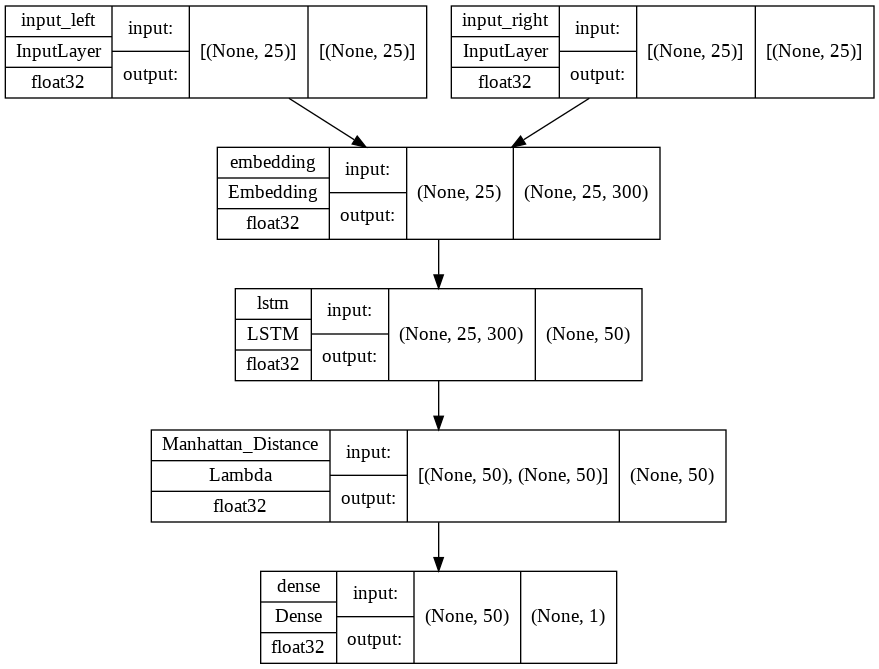

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, expand_nested=True)

In [ ]:
def get_samples(df, max_length):
  left = df[['tokenizer_1']]
  right = df[['tokenizer_2']]
  return sequence.pad_sequences(left.tokenizer_1, maxlen = max_length, padding='post', truncating='post'), sequence.pad_sequences(right.tokenizer_2, maxlen=max_length, padding='post', truncating='post')

In [ ]:
x_train_left, x_train_right = get_samples(train_questions, m_len)
y_train = train_questions[['is_duplicate']]

x_val_left, x_val_right = get_samples(validation_questions, m_len)
y_val = validation_questions[['is_duplicate']]

x_test_left, x_test_right = get_samples(test_questions, m_len)
y_test = test_questions[['is_duplicate']]

In [ ]:
x_train_left.shape == x_train_right.shape

True

In [ ]:
len(x_train_left) == len(y_train)

True

In [ ]:
run_model(model, "siamese_lstm_word2vec-300_m-len-25", [x_train_left, x_train_right], y_train, [x_val_left, x_val_right], y_val, epochs = 10)

In [ ]:
model = keras.models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'siamese_lstm_word2vec-300_m-len-25.h5'))

Classification report: 
              precision    recall  f1-score   support

           0     0.8476    0.8562    0.8519     25348
           1     0.7541    0.7412    0.7476     15080

    accuracy                         0.8133     40428
   macro avg     0.8009    0.7987    0.7997     40428
weighted avg     0.8127    0.8133    0.8130     40428



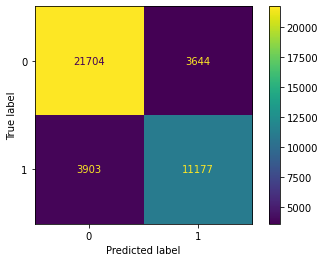

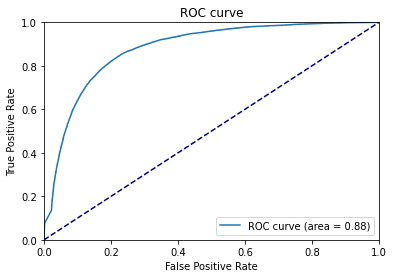

In [ ]:
evaluate_model(model, [x_test_left, x_test_right], y_test)

Epoch 1/10
5053/5054 [============================>.] - ETA: 0s - loss: 0.1083 - accuracy: 0.8587
Epoch 1: val_loss improved from inf to 0.13467, saving model to /content/Models/siamese_lstm_word2vec_2-300_m-len-25.h5
5054/5054 [==============================] - 335s 66ms/step - loss: 0.1083 - accuracy: 0.8587 - val_loss: 0.1347 - val_accuracy: 0.8169
Epoch 2/10
5053/5054 [============================>.] - ETA: 0s - loss: 0.1050 - accuracy: 0.8647
Epoch 2: val_loss did not improve from 0.13467
5054/5054 [==============================] - 324s 64ms/step - loss: 0.1050 - accuracy: 0.8647 - val_loss: 0.1349 - val_accuracy: 0.8160
Epoch 3/10
5053/5054 [============================>.] - ETA: 0s - loss: 0.1019 - accuracy: 0.8701
Epoch 3: val_loss did not improve from 0.13467
5054/5054 [==============================] - 325s 64ms/step - loss: 0.1019 - accuracy: 0.8701 - val_loss: 0.1361 - val_accuracy: 0.8158
Epoch 4/10
5053/5054 [============================>.] - ETA: 0s - loss: 0.0992 - acc

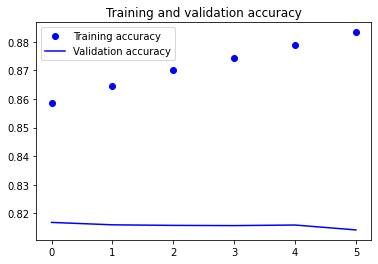

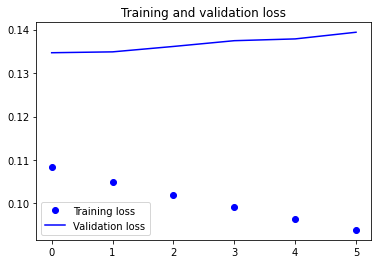

In [ ]:
run_model(model, "siamese_lstm_word2vec_2-300_m-len-25", [x_train_left, x_train_right], y_train, [x_val_left, x_val_right], y_val, epochs = 10)

In [ ]:
with open(os.path.join(HISTORIES_FOLDER, 'siamese_lstm_word2vec-300_m-len-25.csv'), newline='') as csvfile:
  history1 = pd.read_csv(csvfile)

with open(os.path.join(HISTORIES_FOLDER, 'siamese_lstm_word2vec_2-300_m-len-25.csv'), newline='') as csvfile:
  history2 = pd.read_csv(csvfile)

In [ ]:
history = history1.append(history2)

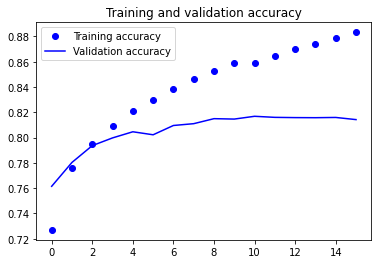

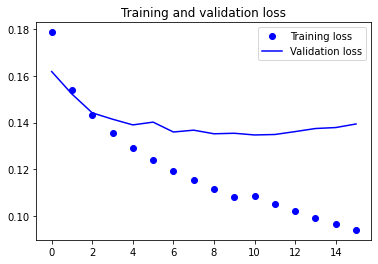

In [ ]:
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Classification report: 
              precision    recall  f1-score   support

           0     0.8689    0.8261    0.8469     25348
           1     0.7300    0.7905    0.7591     15080

    accuracy                         0.8128     40428
   macro avg     0.7995    0.8083    0.8030     40428
weighted avg     0.8171    0.8128    0.8142     40428



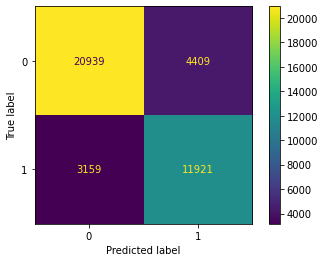

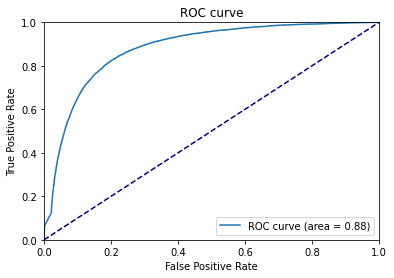

In [ ]:
evaluate_model(model, [x_test_left, x_test_right], y_test)

### Experiment 2: Bi-directional LSTM

In [ ]:
lstm_units = 10

In [ ]:
lstm_layer = layers.Bidirectional(layers.LSTM(
    lstm_units,
    dropout=0.2,
    recurrent_dropout=0.2
))

In [ ]:
input_left = layers.Input(shape=(m_len,), name="input_left")
embedded_sequences_left = embedding_layer(input_left)
lstm_left = lstm_layer(embedded_sequences_left)
input_right = layers.Input(shape=(m_len,), name="input_right")
embedded_sequences_right = embedding_layer(input_right)
lstm_2 = lstm_layer(embedded_sequences_right)
mhd = lambda x: keras.backend.abs(x[0] - x[1]) # Manhattan Distance
merged = layers.Lambda(function=mhd, output_shape=lambda x: x[0], name='Manhattan_Distance')([lstm_left, lstm_2])
preds = layers.Dense(1, activation='sigmoid')(merged)
model = Model(inputs=[input_left, input_right], outputs=preds)
compile_model(model, loss='mse')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_left (InputLayer)        [(None, 25)]         0           []                               
                                                                                                  
 input_right (InputLayer)       [(None, 25)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 25, 300)      29006700    ['input_left[0][0]',             
                                                                  'input_right[0][0]']            
                                                                                                  
 bidirectional (Bidirectional)  (None, 20)           24880       ['embedding[0][0]',          

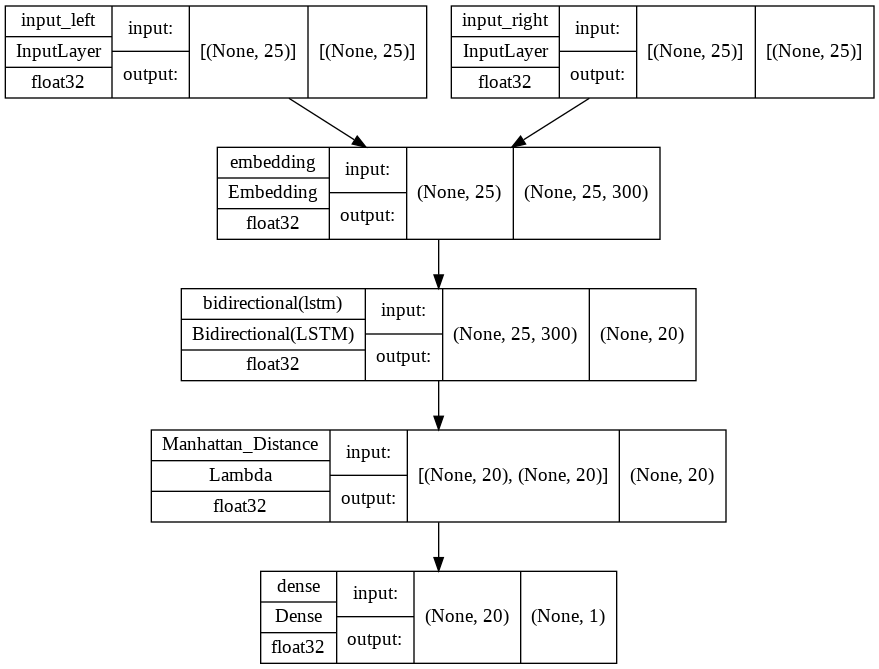

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, expand_nested=True)

In [ ]:
def get_samples(df, max_length):
  left = df[['tokenizer_1']]
  right = df[['tokenizer_2']]
  return sequence.pad_sequences(left.tokenizer_1, maxlen = max_length, padding='post', truncating='post'), sequence.pad_sequences(right.tokenizer_2, maxlen=max_length, padding='post', truncating='post')

In [ ]:
x_train_left, x_train_right = get_samples(train_questions, m_len)
y_train = train_questions[['is_duplicate']]

x_val_left, x_val_right = get_samples(validation_questions, m_len)
y_val = validation_questions[['is_duplicate']]

x_test_left, x_test_right = get_samples(test_questions, m_len)
y_test = test_questions[['is_duplicate']]

In [ ]:
x_train_left.shape == x_train_right.shape

True

In [ ]:
len(x_train_left) == len(y_train)

True

Epoch 1/20
5054/5054 [==============================] - ETA: 0s - loss: 0.1852 - accuracy: 0.7103
Epoch 1: val_loss improved from inf to 0.16604, saving model to /content/Models/siamese_bi_word2vec-300_m-len-25.h5
5054/5054 [==============================] - 1068s 206ms/step - loss: 0.1852 - accuracy: 0.7103 - val_loss: 0.1660 - val_accuracy: 0.7531
Epoch 2/20
5054/5054 [==============================] - ETA: 0s - loss: 0.1654 - accuracy: 0.7517
Epoch 2: val_loss improved from 0.16604 to 0.15711, saving model to /content/Models/siamese_bi_word2vec-300_m-len-25.h5
5054/5054 [==============================] - 1050s 208ms/step - loss: 0.1654 - accuracy: 0.7517 - val_loss: 0.1571 - val_accuracy: 0.7688
Epoch 3/20
5054/5054 [==============================] - ETA: 0s - loss: 0.1594 - accuracy: 0.7631
Epoch 3: val_loss improved from 0.15711 to 0.15279, saving model to /content/Models/siamese_bi_word2vec-300_m-len-25.h5
5054/5054 [==============================] - 1077s 213ms/step - loss: 0.15

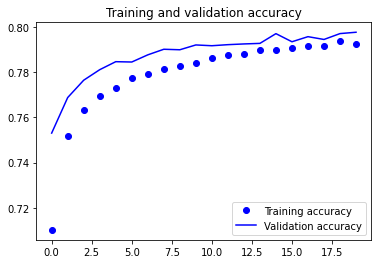

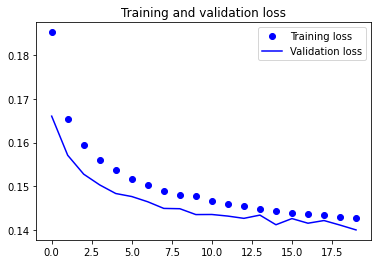

In [ ]:
run_model(model, "siamese_bi_word2vec-300_m-len-25", [x_train_left, x_train_right], y_train, [x_val_left, x_val_right], y_val, epochs = 20)

Classification report: 
              precision    recall  f1-score   support

           0     0.8561    0.8121    0.8336     25348
           1     0.7093    0.7706    0.7387     15080

    accuracy                         0.7967     40428
   macro avg     0.7827    0.7914    0.7861     40428
weighted avg     0.8014    0.7967    0.7982     40428



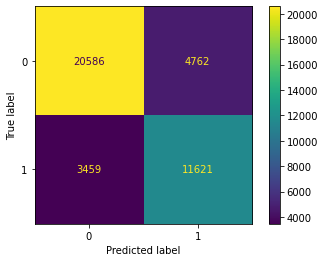

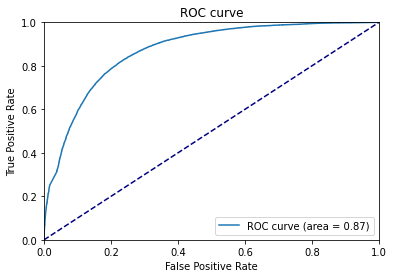

In [ ]:
evaluate_model(model, [x_test_left, x_test_right], y_test)

### Experiment 3: LSTM with trainable embeddings

In [ ]:
model = keras.models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'siamese_lstm_word2vec_2-300_m-len-25.h5'))

In [ ]:
for layer in model.layers:
  if layer.name == 'embedding':
    layer.trainable = True
compile_model(model, loss='mse')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_left (InputLayer)        [(None, 25)]         0           []                               
                                                                                                  
 input_right (InputLayer)       [(None, 25)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 25, 300)      29006700    ['input_left[0][0]',             
                                                                  'input_right[0][0]']            
                                                                                                  
 lstm (LSTM)                    (None, 50)           70200       ['embedding[0][0]',          

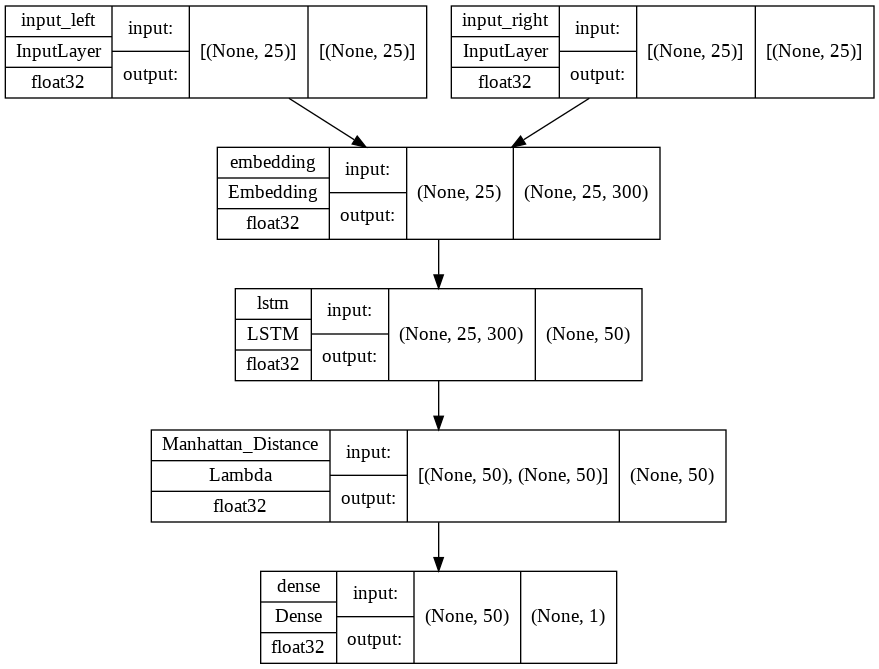

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, expand_nested=True)

In [ ]:
def get_samples(df, max_length):
  left = df[['tokenizer_1']]
  right = df[['tokenizer_2']]
  return sequence.pad_sequences(left.tokenizer_1, maxlen = max_length, padding='post', truncating='post'), sequence.pad_sequences(right.tokenizer_2, maxlen=max_length, padding='post', truncating='post')

In [ ]:
x_train_left, x_train_right = get_samples(train_questions, m_len)
y_train = train_questions[['is_duplicate']]

x_val_left, x_val_right = get_samples(validation_questions, m_len)
y_val = validation_questions[['is_duplicate']]

x_test_left, x_test_right = get_samples(test_questions, m_len)
y_test = test_questions[['is_duplicate']]

In [ ]:
x_train_left.shape == x_train_right.shape

True

In [ ]:
len(x_train_left) == len(y_train)

True

Epoch 1/10
5054/5054 [==============================] - ETA: 0s - loss: 0.1178 - accuracy: 0.8382
Epoch 1: val_loss improved from inf to 0.11884, saving model to /content/Models/siamese_lstm_trainable_word2vec-300_m-len-25.h5
5054/5054 [==============================] - 1876s 369ms/step - loss: 0.1178 - accuracy: 0.8382 - val_loss: 0.1188 - val_accuracy: 0.8364
Epoch 2/10
5054/5054 [==============================] - ETA: 0s - loss: 0.0781 - accuracy: 0.8987
Epoch 2: val_loss improved from 0.11884 to 0.11606, saving model to /content/Models/siamese_lstm_trainable_word2vec-300_m-len-25.h5
5054/5054 [==============================] - 1841s 364ms/step - loss: 0.0781 - accuracy: 0.8987 - val_loss: 0.1161 - val_accuracy: 0.8425
Epoch 3/10
5054/5054 [==============================] - ETA: 0s - loss: 0.0543 - accuracy: 0.9336
Epoch 3: val_loss did not improve from 0.11606
5054/5054 [==============================] - 1784s 353ms/step - loss: 0.0543 - accuracy: 0.9336 - val_loss: 0.1164 - val_ac

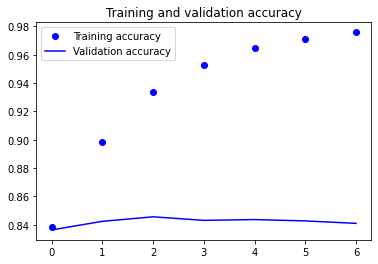

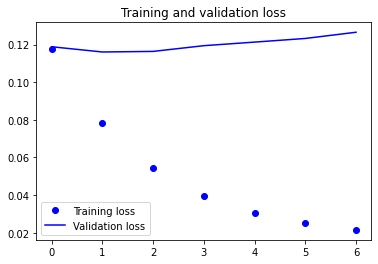

In [ ]:
run_model(model, "siamese_lstm_trainable_word2vec-300_m-len-25", [x_train_left, x_train_right], y_train, [x_val_left, x_val_right], y_val, epochs = 10)

In [ ]:
model = keras.models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'siamese_lstm_trainable_word2vec-300_m-len-25.h5'))

Classification report: 
              precision    recall  f1-score   support

           0     0.8743    0.8722    0.8732     25348
           1     0.7860    0.7893    0.7876     15080

    accuracy                         0.8412     40428
   macro avg     0.8302    0.8307    0.8304     40428
weighted avg     0.8414    0.8412    0.8413     40428



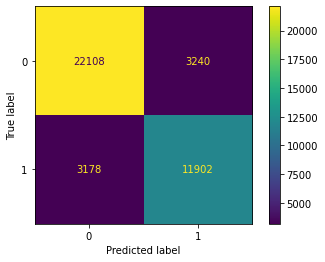

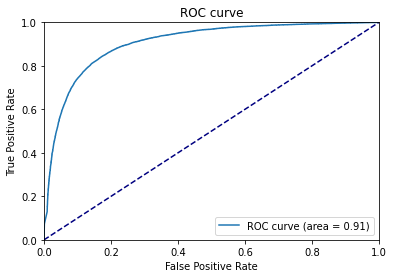

In [ ]:
evaluate_model(model, [x_test_left, x_test_right], y_test)